In [1]:
# !pip install tensorflow gym keras-rl gym[atari]
!pip install tensorflow gym keras-rl 'gym[atari]' 'gym[accept-rom-license]' opencv-python
# !pip install opencv-python

ERROR: Invalid requirement: "'gym[atari]'"


In [2]:
import gym 
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2

Pre-proccessing 

In [127]:
def resize_frame(frame):
    frame = np.average(frame,axis = 2)
    frame = frame[30:-5,:]
    frame = cv2.resize(frame,(84,84),interpolation = cv2.INTER_NEAREST)
    frame = np.array(frame,dtype = np.uint8)
    frame = np.expand_dims(frame, axis=-1)
    frame = np.repeat(frame, 3, axis=-1)
    return frame

Class For Memory Buffer

In [172]:
#class for storing experiences of the agent. Has a fixed size that when it
#reaches the end of, it overwrites what was at the start
class Memory(object):
    def __init__(self, input_shape, num_actions, buffer_size, batch_size):
        self.states = np.zeros((buffer_size,) + input_shape)
        self.next_states = np.zeros((buffer_size,) + input_shape)
        self.actions = np.zeros(buffer_size, dtype=np.uint8)
        self.rewards = np.zeros(buffer_size)
        self.terminal = np.zeros(buffer_size)
        self.buffer_index = 0
        self.buffer_size = buffer_size
        self.batch_size = batch_size

    def save_action(self, state, action, reward, next_state, done):
        self.states[self.buffer_index] = state
        self.next_states[self.buffer_index] = next_state
        self.actions[self.buffer_index] = action
        self.rewards[self.buffer_index] = reward
        self.terminal[self.buffer_index] = 1 - int(done)
        self.buffer_index = (self.buffer_index + 1) % self.buffer_size

    def sample_memory(self):
        indicies = np.random.randint(0, self.buffer_index, self.batch_size)
        return self.states[indicies], self.actions[indicies], self.rewards[indicies], self.next_states[indicies], self.terminal[indicies]
    



Function For Deep Q Network

In [173]:
#from keras exactly, site if using!!!
def init_deep_q_network(input_shape, lr, num_actions, l1_size, l2_size):
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=input_shape)

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)

Class For Learning Agent

In [174]:
class Agent(object):
    def __init__(self, alpha, gamma, actions_amt, epsilon, input_shape, input_shape_attention=(84, 84, 3), epsilon_dec=0.996, epsilon_end=0.01,  batch_size=64, fname='dqn_model.h5', buffer_size=1000, window_x=50, window_y=80):
        self.alpha = alpha
        self.gamma = gamma
        self.actions_amt = actions_amt
        self.epsilon = epsilon 
        self.input_shape = input_shape
        self.input_shape_attention = input_shape
        self.epsilon_dec = epsilon_dec
        self.epsilon_end = epsilon_end
        self.fname = fname
        self.q_network = init_deep_q_network(input_shape, alpha, actions_amt, 256, 256)
        self.q_network_target = init_deep_q_network(input_shape, alpha, actions_amt, 256, 256)
        self.attention_q = init_deep_q_network(input_shape_attention, alpha, actions_amt, 256, 256)
        self.attention_q_target = init_deep_q_network(input_shape_attention, alpha, actions_amt, 256, 256)
        self.memory = Memory(input_shape, actions_amt, buffer_size, batch_size)
        self.loss_function = keras.losses.Huber()
        self.optimizer = keras.optimizers.legacy.Adam(learning_rate=0.00025, clipnorm=1.0)
        self.model_file = "rl_agent"
        self.attention_model_file = "attention_network"
        self.window_x = window_x
        self.window_y = window_y


    def select_action(self, input, actor=True): 
        if actor:
            network = self.q_network
            num_actions = self.actions_amt
        else: 
            network = self.attention_q
            num_actions = 5
        if np.random.rand() > self.epsilon:
            action_values = network.predict(input[None,...], verbose=0)
            action = np.argmax(action_values)
        else:
            action = np.random.choice(num_actions)
        
        return action 
    
    def store_action(self, state, action, reward, next_state, done, actor=True):
        self.memory.save_action(state, action, reward, next_state, done)

    def learn(self, actor=True):
        if actor:
            network = self.q_network
            target_network = self.q_network_target
        else: 
            network = self.attention_q
            target_network = self.attention_q_target
        #print("calling learn")
        states, actions, rewards, new_states, dones = self.memory.sample_memory()
        states = tf.stack(states)
        actions = tf.stack(actions)
        new_states = tf.stack(new_states)
        dones = tf.stack(dones)
        new_states = tf.stack(new_states)
        future_rewards = target_network.predict(new_states, verbose=0)
        updated_qs = rewards + self.gamma * tf.reduce_max(future_rewards, axis=1)
        masks = tf.one_hot(actions, self.actions_amt)
        #print("before gradient tape section")
        with tf.GradientTape() as tape:
            q_values = network(states)
            q_actions = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
            loss = self.loss_function(updated_qs, q_actions)
        grads = tape.gradient(loss, network.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, network.trainable_variables))
        target_network.set_weights(network.get_weights())
        
        if self.epsilon > self.epsilon_end:
            self.epsilon -= self.epsilon_dec

    def set_focal_pont(self):
        x = 210
        y = 160
        x_init = (x / 2) - (self.window_x / 2)
        y_init = self.window_y / 2
        self.focal_point = (x_init, y_init)

    def move_focal_point(self, action, stride=5):
        x,y = self.focal_point
        if action == 0:
            x = x - stride
        if action == 1:
            x = x + stride
        if action == 2:
            y = y + stride
        if action == 3:
            y = y - stride
        self.focal_point = (x,y)
    
    def extract_frame(self, input):
        focal_point = self.focal_point
        x_len, y_len = self.window_x, self.window_y
        max_x, max_y,_ = np.shape(input)
        x,y = focal_point
        x_half = x_len / 2
        y_half = y_len /2
        x_left = x - x_half
        x_right = x + x_half
        y_up = y + y_half
        y_down = y - y_half
        if x_left < 0:
            x_left = 0
            x_right = x_len
        if x_right > max_x - 1:
            x_right = max_x - 1
            x_left = x_right - x_len
        if y_up > max_y - 1:
            y_up = max_y - 1
            y_down = y_up - y_len
        if y_down < 0:
            y_down = 0
            y_up = y_down + y_len
        x_left = int(x_left)
        x_right = int(x_right)
        y_up = int(y_up)
        y_down = int(y_down)
        frame = input[x_left:x_right, y_down:y_up]
        return frame
    
    def save_model(self, actor=True):
        if actor:
            network = self.q_network
            file = self.model_file
        else: 
            network = self.attention_q
            file = self.attention_model_file
        
        network.save(file)

    def load_model(self):
        self.q_network = load_model(self.model_file)
        

        

Run Learning Loop

In [183]:
import time
#env = gym.make('Breakout-v4')
env = gym.make('Breakout-v4', render_mode='human')
n_games = 150001
agent = Agent(gamma=.99, epsilon=.5, alpha=.0005, actions_amt=4, input_shape=(84, 84, 3), batch_size=32, epsilon_end=0.01, buffer_size=1000, epsilon_dec=.01, window_x=84, window_y=84)
agent.set_focal_pont()
scores = []
eps_history = []

for i in range(n_games):
    done = False
    score = 0
    observation = env.reset()
    observation = observation[0]
    observation = agent.extract_frame(observation)
    j = 0
    while not done: 
        st = time.time()
        action = agent.select_action(observation)
        fp_action = agent.select_action(observation, actor=False)
        agent.move_focal_point(fp_action)
        observation_, reward, done, truncated, info = env.step(action)
        observation_ = agent.extract_frame(observation_)
        score += reward
        agent.store_action(observation, action, reward, observation_, done)
        agent.store_action(observation, action, reward, observation_, done, actor=False)
        observation = observation_
        et= time.time()
        j += 1 
        if j == 100:
            agent.learn()
            agent.learn(actor=False)

    eps_history.append(agent.epsilon)
    scores.append(score)

    avg_score = np.mean(scores[max(0, 1 - 100):(i + 1)])
    #if i % 10 == 0:
    print("episode ", i, "score %.2f" % score, 'average score %.2f' % avg_score)

    #if i % 10 == 0 and i > 0: 
        #agent.save_model()

c:\Users\micha\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


[142 142 142]


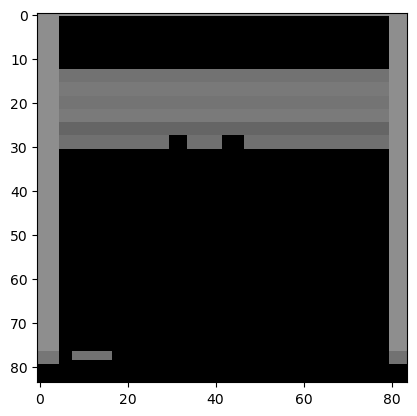

In [156]:
print((observation[0][0]))
plt.imshow(observation)